In [1]:
using LinearAlgebra

# Matrix multiplication

```
// input: A, B
// output: C
function binete_algorithm(A, B, C) {
    
    if (A.size > 2) {
        a11, a12, a21, a22 = A[range_A].slice_into_quarters();
        b11, b12, b21, b22 = B[range_B].slice_into_quarters();
        c11, c12, c21, c22 = C[range_C].slice_into_quarters();
        
        // up-left
        binete_algorithm(a11, b11, c11);
        binete_algorithm(a12, b21, c11);

        // up-right
        binete_algorithm(a11, b12, c12);
        binete_algorithm(a12, b22, c12);

        // down-left
        binete_algorithm(a21, b11, c21);
        binete_algorithm(a22, b21, c21);

        // down-right
        binete_algorithm(a21, b12, c22);
        binete_algorithm(a22, b22, c22);
    } else {
        mat_mul(A, B, C); // do traditional matrix multiplication
    }
}
```

In [2]:
function classic_(A, B, C)
    len = size(A,1)
    for i in 1:len
       for j in 1:len
           for k in 1:len
                C[i, j] += (A[i, k] * B[k, j])
            end
        end
    end
    return C
end

classic_ (generic function with 1 method)

In [3]:
FLOPS = 0
function multiply_rec_(A, B, C)
    if size(A,1) == 2
        classic_(A, B, C)
        global FLOPS += 8
        return C
    end
    len = (size(A,1)÷2)
    a11 = [1:len,1:len]
    a12 = [1:len,len+1:len*2]
    a21 = [len+1:len*2,1:len]
    a22 = [len+1:len*2,len+1:len*2]

    multiply_rec_(
        A[a11...], 
        B[a11...],
        @view C[a11...]
    )
    multiply_rec_(
        A[a12...], 
        B[a21...],
        @view C[a11...]
    )

    multiply_rec_(
        A[a11...], 
        B[a12...],
        @view C[a12...]
    )
    multiply_rec_(
        A[a12...], 
        B[a22...],
        @view C[a12...]
    )

    multiply_rec_(
        A[a21...], 
        B[a11...],
        @view C[a21...]
    )
    multiply_rec_(
        A[a22...], 
        B[a21...],
        @view C[a21...]
    )
    
    multiply_rec_(
        A[a21...], 
        B[a12...],
        @view C[a22...]
    )
    multiply_rec_(
        A[a22...], 
        B[a22...],
        @view C[a22...]
    )
end

function multiply_rec(A, B)
    C = zeros(size(A,1), size(B,2))
    multiply_rec_(A, B, C)
    return C
end

multiply_rec (generic function with 1 method)

# Matrix inverse

```
// input: A - matrix to inverse, B - result matrix
function inv(A, B)
    len = size(A) / 2
    
    if len == 1
        B = classic_2x2_inverse(A)
    else
        a11, a12, a21, a22 = <A matrix indexing for each quater>

        inv(A[a11], invA11)

        S22 = A[a22] - multiply_rec( 
            multiply_rec(A[a21], invA11), 
            A[a12]
        )

        inv_rec(S22, invS22)

        B[a11] = multiply_rec(
            invA11, 
            I + multiply_rec(
                    multiply_rec(
                        multiply_rec(A[a12], invS22), 
                        A[a21]
                    ), 
                    invA11
            )
        )
        B[a12] = multiply_rec(multiply_rec(-invA11, A[a12]), invS22)
        B[a21] = multiply_rec(multiply_rec(-invS22, A[a21]), invA11)
        B[a22] = invS22
end
```

In [4]:
function inv2x2(A)
    detA = A[1, 1]*A[2, 2] - A[1, 2]*A[2, 1]
    invA = [
        A[2, 2] -A[1, 2]
        -A[2, 1] A[1, 1]
    ]
    return (1/detA)*invA
end

function inv_rec(A, B)
    len = size(A,1) ÷ 2
    
    if size(A, 1) == 2
        B[:, :] = inv2x2(A)
        global FLOPS += 8
        return
    end
    
    a11 = [1:len,1:len]
    a12 = [1:len,len+1:len*2]
    a21 = [len+1:len*2,1:len]
    a22 = [len+1:len*2,len+1:len*2]

    invA11 = my_inv(A[a11...])
    
    S22 = A[a22...] - multiply_rec(
        multiply_rec(A[a21...], invA11), 
        A[a12...]
    )
        
    invS22 = my_inv(S22)
    Id = Matrix(1.0I, len, len)
    
    B[a11...] = multiply_rec(
        invA11, 
        Id + multiply_rec(
            multiply_rec(
                multiply_rec(A[a12...], invS22), 
                A[a21...]
            ), 
            invA11
        )
    )
    global FLOPS += 2 
    B[a12...] = multiply_rec(multiply_rec(-invA11, A[a12...]), invS22)
    B[a21...] = multiply_rec(multiply_rec(-invS22, A[a21...]), invA11)
    B[a22...] = invS22
end

function my_inv(A:: Matrix)
    B = 1.0 * zeros(size(A,1), size(A,1))
    inv_rec(A, B)
    return B
end

my_inv (generic function with 1 method)

# Plots

In [8]:
using Plots

function test_time_inv(n)
    times = zeros(n)
    flops = zeros(n)
    for i in 1:n
        A = rand(2^i, 2^i)
        global FLOPS = 0
        times[i] = @elapsed my_inv(A)
        flops[i] = FLOPS
        println("n=$i, time=$(times[i]), flops=$(flops[i])")
        flush(stdout)
    end
    return times, flops
end

times, flops = test_time_inv(10)

n=1, time=7.375e-6, flops=8.0
n=2, time=2.0417e-5, flops=98.0
n=3, time=5.2542e-5, flops=838.0
n=4, time=0.000443625, flops=6798.0
n=5, time=0.003164583, flops=54558.0
n=6, time=0.046712625, flops=436798.0
n=7, time=0.352429583, flops=3.495038e6
n=8, time=1.49187225, flops=2.7961598e7
n=9, time=11.696615834, flops=2.23695358e8
n=10, time=97.297025834, flops=1.789567998e9


([7.375e-6, 2.0417e-5, 5.2542e-5, 0.000443625, 0.003164583, 0.046712625, 0.352429583, 1.49187225, 11.696615834, 97.297025834], [8.0, 98.0, 838.0, 6798.0, 54558.0, 436798.0, 3.495038e6, 2.7961598e7, 2.23695358e8, 1.789567998e9])

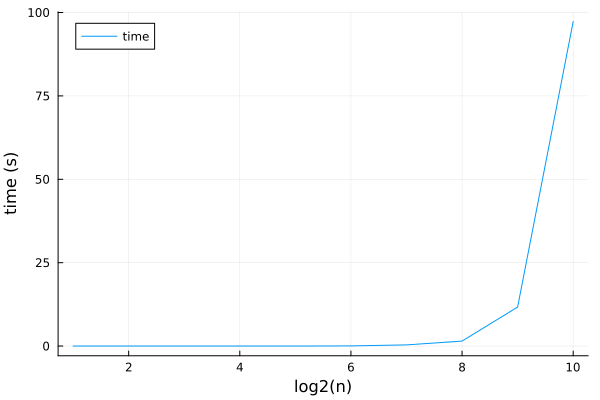

In [9]:
plot(times, label="time", xlabel="log2(n)", ylabel="time (s)")


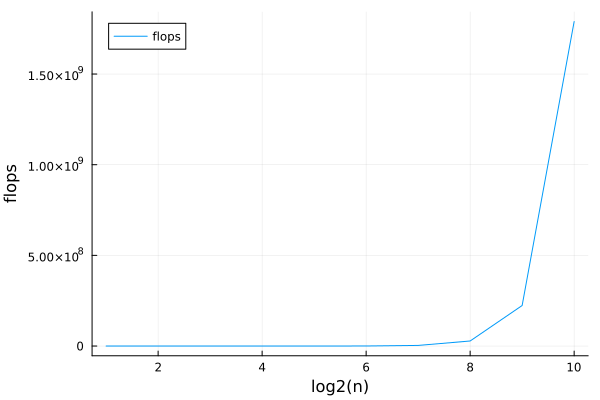

In [10]:
plot(flops, label="flops", xlabel="log2(n)", ylabel="flops")